In [93]:
# !pip install tqdm 
# from tdqm import tqdm
import matplotlib
import os
from tqdm import tqdm
import json
from json import JSONDecodeError
import pickle
import numpy as np
from nltk.translate import bleu_score
from matplotlib import pyplot as plt

Note: most relevant stuff can be found in `test captions.ipynb`

In [9]:
from utils import load_vocab, decode_caption, load_caption, rrv_votes, load_annotations, print_image

In [10]:
ngram_similarities = ["unigram_overlap", "unigram_multiplicity", "bigram_overlap", "bigram_precision"]

In [11]:
vocab = load_vocab(dict_file = "../../outputs/vocab/5000/coco2014_vocab.json")
image_id_to_index, index_to_image_id, annotations_dict = load_annotations(annotations_dir="../../annotations/", 
                                                                          annotations_file='captions_val2014.json',
                                                                         map_file = "../../outputs/val_image_id_to_idx.csv")
print("Processed {} images".format(len(image_id_to_index)))
print("Processed {} images".format(len(annotations_dict.keys())))

word_to_idx
idx_to_word
Loaded dictionary...
Dictionary size: 5004
Error proccessing image_id: image_index
Skipping file person_keypoints_train2014.json
Skipping file instances_train2014.json
Skipping file instances_val2014.json
Skipping file person_keypoints_val2014.json
Processed 40504 images
Processed 40504 images


## Generate and save voted captions

In [12]:
def load_best_beam_captions(beam_size):
#     beam_captions = {}
#     beam_captions_dir = "../../outputs/beam_captions_{}/".format(beam_size)
#     for image_id in sorted(annotations_dict):
#         caption_object = load_caption(image_id, image_dir=beam_captions_dir)
#         best_beam_caption = caption_object['captions'][0]['sentence']
#         beam_captions[image_id] = best_beam_caption
#     return beam_captions
    file_name = '../../outputs/voted_captions/{}/best_beam.pickle'.format(beam_size)
#     with open(file_name, 'wb') as file:
#         pickle.dump(beam_captions, file, pickle.HIGHEST_PROTOCOL)
    with open(file_name, 'rb') as file:
        best_beams = pickle.load(file)
    return [decode_caption(best_beams[im_id], vocab) for im_id in sorted(best_beams)]

In [13]:
def save_beam_baseline_captions(beam_size):
    beam_baseline_captions = []
    beam_captions_dir = "../../outputs/beam_captions_{}/".format(beam_size)
    for image_id in sorted(annotations_dict):
        caption_object = load_caption(image_id, image_dir=beam_captions_dir)
        probabilities = caption_object['probabilities']
        captions = [caption_object['captions'][i]['sentence'] for i in range(len(caption_object['captions']))]
        log_probs = np.log(probabilities)
        log_probs_and_captions = list(zip(log_probs, captions))
        normalilzed_log_probs_and_captions = [(p / len(c), c) for p,c in log_probs_and_captions]
        baseline_caption = sorted(normalilzed_log_probs_and_captions, reverse=True)[0][1]
        beam_baseline_captions.append(baseline_caption)
    print("saving {} baseline captions for k={}".format(len(beam_baseline_captions), beam_size))
    file_name = '../../outputs/voted_captions/{}/beam_baseline.pickle'.format(beam_size)
    with open(file_name, 'wb') as file:
        best_beams = pickle.dump(beam_baseline_captions, file, pickle.HIGHEST_PROTOCOL)
        
def load_beam_baseline_captions(beam_size):
    file_name = '../../outputs/voted_captions/{}/beam_baseline.pickle'.format(beam_size)
    with open(file_name, 'rb') as file:
        return pickle.load(file)
    
def extract_baseline_sentences(captions):
    return [decode_caption(c, vocab) for c in captions]

In [14]:
def generate_vote_captions(beam_size, similarity):
    """Compute a dictionary of captions, generated using range voting."""
    vote_captions = {}
    beam_captions_dir = "../../outputs/beam_captions_{}/".format(beam_size)
    images = os.listdir(beam_captions_dir)
    print("Number of images with beam captions found: {}".format(len(images)))

    for i, image in enumerate(tqdm(images)):
        image_id = int(image.split('.')[0])
        try:
            caption_object = load_caption(image_id, image_dir=beam_captions_dir)
            voted_caption_object = rrv_votes(caption_object, num_winners=1, similarity=similarity)
            vote_captions[image_id] = voted_caption_object
        except JSONDecodeError:
            print("Error on ", image_id)
    return vote_captions

In [15]:
def save_vote_captions(captions, beam_size, similarity):
    file_name = '../../outputs/voted_captions/{}/{}.pickle'.format(beam_size, similarity)
    if os.path.isfile(file_name): 
        raise ValueError("File {} already exists".format(file_name))
    with open(file_name, 'wb') as file:
        pickle.dump(captions, file, pickle.HIGHEST_PROTOCOL)

def load_voted_captions(beam_size, similarity):
    file_name = '../../outputs/voted_captions/{}/{}.pickle'.format(beam_size, similarity)
    with open(file_name, 'rb') as file:
        return pickle.load(file)

def extract_caption_tokens(voted_captions):
    caption_tokens = []
    for image_id in sorted(annotations_dict):
        caption_tokens.append(voted_captions[image_id][0][0])
    return caption_tokens

def extract_caption_sentences(voted_captions):
    caption_sentences = []
    for image_id in sorted(annotations_dict):
        caption_sentences.append(decode_caption(voted_captions[image_id][0][0], vocab))
    return caption_sentences

In [16]:
beam_size = 100
for similarity in ngram_similarities:
    voted_captions = generate_vote_captions(beam_size, similarity)
    save_vote_captions(voted_captions, beam_size, similarity)

  0%|          | 1/40504 [00:00<1:30:35,  7.45it/s]

Number of images with beam captions found: 40504


  0%|          | 49/40504 [00:06<1:37:12,  6.94it/s]


KeyboardInterrupt: 

## Bleu score

In [18]:
annotations_list = [annotations_dict[image_id] for image_id in sorted(annotations_dict)]

In [138]:
beam_baseline_captions = load_voted_captions(10, 'unigram_overlap')
print(beam_baseline_captions[0])

([array([  1,   4,  13,  47,   4,  92,  36,   7,  70,   6,   4, 363,   2])], [0.008501648821525572], [0.02093808164473165])


In [139]:
for k in [1, 2, 10, 100]:
    beam_captions = load_best_beam_captions(k)
    bleu = bleu_score.corpus_bleu(annotations_list, beam_captions)
    print("Bleu score for {}/beam: {}".format(k, bleu))

Bleu score for 1/beam: 0.2538667841440404
Bleu score for 2/beam: 0.2682792451263592
Bleu score for 10/beam: 0.2716384032063896
Bleu score for 100/beam: 0.2630932525817317


In [149]:
for k in [2, 10, 100]:
    beam_baseline_captions = extract_baseline_sentences(load_beam_baseline_captions(k))
    bleu = bleu_score.corpus_bleu(annotations_list, beam_baseline_captions)
    print("Bleu score for {}/baseline: {}".format(k, bleu))

Bleu score for 2/baseline: 0.26719194279794856
Bleu score for 10/baseline: 0.2575805705250495
Bleu score for 100/baseline: 0.24728679506549345


In [40]:
for k in [2, 10, 100]:
    for similarity in ngram_similarities:
#     for similarity in ["unigram_overlap"]:
        voted_captions = load_voted_captions(k, similarity)
        caption_sentences = extract_caption_sentences(voted_captions)
        bleu = bleu_score.corpus_bleu(annotations_list, caption_sentences)
        print("Bleu score for {}/{}: {}".format(k, similarity, bleu))
        
load_best_beam_captions(beam_size):


Bleu score for 2/unigram_overlap: 0.26471592485004636
Bleu score for 2/unigram_multiplicity: 0.26465035752639743
Bleu score for 2/bigram_overlap: 0.26819492239283405
Bleu score for 2/bigram_precision: 0.2682133866459531
Bleu score for 10/unigram_overlap: 0.256075134051543
Bleu score for 10/unigram_multiplicity: 0.25617128598109506
Bleu score for 10/bigram_overlap: 0.2722419757177174
Bleu score for 10/bigram_precision: 0.27225372664595027
Bleu score for 100/unigram_overlap: 0.24599352328777574
Bleu score for 100/unigram_multiplicity: 0.2458465783961177
Bleu score for 100/bigram_overlap: 0.27129324857796216
Bleu score for 100/bigram_precision: 0.27127390477094687


### Bleu scores without special tokens (UNK, ...):
- Bleu score for unigram_overlap: 0.26467988807445114
- Bleu score for unigram_multiplicity: 0.2645384759015102
- Bleu score for bigram_overlap: 0.26756545082955885
- Bleu score for bigram_precision: 0.267569847775782

### Bleu scores with special tokens:
- Bleu score for 2/unigram_overlap: 0.26471592485004636
- Bleu score for 2/unigram_multiplicity: 0.26465035752639743
- Bleu score for 2/bigram_overlap: 0.26819492239283405
- Bleu score for 2/bigram_precision: 0.2682133866459531
- Bleu score for 10/unigram_overlap: 0.256075134051543
- Bleu score for 10/unigram_multiplicity: 0.25617128598109506
- Bleu score for 10/bigram_overlap: 0.2722419757177174
- Bleu score for 10/bigram_precision: 0.27225372664595027
- Bleu score for 100/unigram_overlap: 0.24599352328777574
- Bleu score for 100/unigram_multiplicity: 0.2458465783961177
- Bleu score for 100/bigram_overlap: 0.27129324857796216
- Bleu score for 100/bigram_precision: 0.27127390477094687

In [91]:
for similarity in ngram_similarities:
    for k in [2, 10, 100]:
        voted_captions = load_voted_captions(k, similarity)
        captions_tokens = extract_caption_tokens(voted_captions)
        file_name = "../../outputs/captions_tokens/{}/{}.pickle".format(k, similarity)
        with open(file_name, "wb") as file:
            pickle.dump(captions_tokens, file, pickle.HIGHEST_PROTOCOL)

## Caption lengths

In [78]:
def caption_length(captions):
    return np.mean([len(c) for c in captions])

In [112]:
for k in [1, 2, 10, 100]:
    beam_captions = load_best_beam_captions(k)
    print("Caption length for {}/beam: {}".format(k, caption_length(beam_captions)))

Caption length for 1/bigram_precision: 8.406478372506418
Caption length for 2/bigram_precision: 8.788169069721508
Caption length for 10/bigram_precision: 9.183562117321745
Caption length for 100/bigram_precision: 9.109668180920403


In [152]:
for k in [2, 10, 100]:
    beam_baseline_captions = extract_baseline_sentences(load_beam_baseline_captions(k))
    print("Caption length for {}/baseline: {}".format(k, caption_length(beam_baseline_captions)))

Caption length for 2/baseline: 9.188845546118902
Caption length for 10/baseline: 10.238741852656528
Caption length for 100/baseline: 10.432846138652973


In [79]:
for similarity in ngram_similarities:
    for k in [2, 10, 100]:
        voted_captions = load_voted_captions(k, similarity)
        caption_sentences = extract_caption_sentences(voted_captions)
        print("Caption length for {}/{}: {}".format(k, similarity, caption_length(caption_sentences)))

Caption length for 2/unigram_overlap: 9.215929290934229
Caption length for 10/unigram_overlap: 10.397121271973138
Caption length for 100/unigram_overlap: 11.194449930871025
Caption length for 2/unigram_multiplicity: 9.20684376851669
Caption length for 10/unigram_multiplicity: 10.375913490025676
Caption length for 100/unigram_multiplicity: 11.149244519059845
Caption length for 2/bigram_overlap: 8.961855619198104
Caption length for 10/bigram_overlap: 9.862433339917045
Caption length for 100/bigram_overlap: 10.54631641319376
Caption length for 2/bigram_precision: 8.961682796760813
Caption length for 10/bigram_precision: 9.860112581473434
Caption length for 100/bigram_precision: 10.545872012640727


## Unique captions

In [68]:
def num_unique(captions):
    caption_strings = [" ".join(c) for c in captions]
    return len(np.unique(caption_strings))

In [116]:
for k in [1, 2, 10, 100]:  
    beam_captions = load_best_beam_captions(k)
    print("Unique captions for beam/{}: {}".format(k, num_unique(beam_captions)))       

Unique captions for beam/1: 9141
Unique captions for beam/2: 9208
Unique captions for beam/10: 5488
Unique captions for beam/100: 4150


In [154]:
for k in [2, 10, 100]:
    beam_baseline_captions = extract_baseline_sentences(load_beam_baseline_captions(k))
    print("Unique captions for {}/baseline: {}".format(k, num_unique(beam_baseline_captions)))

Unique captions for 2/baseline: 9978
Unique captions for 10/baseline: 6418
Unique captions for 100/baseline: 5039


In [73]:
for similarity in ngram_similarities:
    for k in [2, 10, 100]:
        voted_captions = load_voted_captions(k, similarity)
        caption_sentences = extract_caption_sentences(voted_captions)
        print("Unique captions for {}/{}: {}".format(k, similarity, num_unique(caption_sentences)))       


Unique captions for 2/unigram_overlap: 10727
Unique captions for 10/unigram_overlap: 8916
Unique captions for 100/unigram_overlap: 10808
Unique captions for 2/unigram_multiplicity: 10727
Unique captions for 10/unigram_multiplicity: 8902
Unique captions for 100/unigram_multiplicity: 10768
Unique captions for 2/bigram_overlap: 9519
Unique captions for 10/bigram_overlap: 7598
Unique captions for 100/bigram_overlap: 9221
Unique captions for 2/bigram_precision: 9522
Unique captions for 10/bigram_precision: 7590
Unique captions for 100/bigram_precision: 9248


## Captions used once

In [58]:
def num_used_once(captions):
    caption_strings = [" ".join(c) for c in captions]
    _, num_uses = np.unique(caption_strings, return_counts=True)
    return np.sum(num_uses == 1)

In [114]:
for k in [1, 2, 10, 100]:  
    beam_captions = load_best_beam_captions(k)
    print("Captions used once only forb beam/{}: {}".format(k, num_used_once(beam_captions)))       

Captions used once only forb beam/1: 5421
Captions used once only forb beam/2: 5491
Captions used once only forb beam/10: 2888
Captions used once only forb beam/100: 1955


In [155]:
for k in [2, 10, 100]:
    beam_baseline_captions = extract_baseline_sentences(load_beam_baseline_captions(k))
    print("Caption used once only for {}/baseline: {}".format(k, num_used_once(beam_baseline_captions)))

Caption used once only for 2/baseline: 6096
Caption used once only for 10/baseline: 3584
Caption used once only for 100/baseline: 2621


In [115]:
for similarity in ngram_similarities:
    for k in [2, 10, 100]:
        voted_captions = load_voted_captions(k, similarity)
        caption_sentences = extract_caption_sentences(voted_captions)
        print("Captions used once only for {}/{}: {}".format(k, similarity, num_used_once(caption_sentences)))    

Captions used once only for 2/unigram_overlap: 6662
Captions used once only for 10/unigram_overlap: 5273
Captions used once only for 100/unigram_overlap: 6658
Captions used once only for 2/unigram_multiplicity: 6656
Captions used once only for 10/unigram_multiplicity: 5244
Captions used once only for 100/unigram_multiplicity: 6589
Captions used once only for 2/bigram_overlap: 5731
Captions used once only for 10/bigram_overlap: 4369
Captions used once only for 100/bigram_overlap: 5370
Captions used once only for 2/bigram_precision: 5733
Captions used once only for 10/bigram_precision: 4361
Captions used once only for 100/bigram_precision: 5415


## Qualitative analysis

In [29]:
# Compute the bleu score per image
beam_sentence_bleus = []
k = 10
beam_captions = load_best_beam_captions(k)
for beam_caption, annotations in zip(beam_captions, annotations_list):
    beam_sentence_bleus.append(bleu_score.sentence_bleu(annotations, beam_caption))
    
print("Bleu scores: {}".format(len(beam_sentence_bleus)))

/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Bleu scores: 40504


In [30]:
k = 10
similarity ='bigram_overlap'
vote_sentence_bleus = []
voted_captions = load_voted_captions(k, similarity)
caption_sentences = extract_caption_sentences(voted_captions)
for vote_caption, annotations in zip(caption_sentences, annotations_list):
    vote_sentence_bleus.append(bleu_score.sentence_bleu(annotations, vote_caption))
print("Bleu scores: {}".format(len(vote_sentence_bleus)))

0it [00:00, ?it/s]/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
40504it [00:27, 1460.42it/s]

Bleu scores: 40504


In [31]:
diff_idxs = np.argsort(np.array(vote_sentence_bleus) - np.array(beam_sentence_bleus))

In [56]:
import importlib
import utils
importlib.reload(utils)


Bigram overlap:	0.2438	a group of horses standing on top of a grass covered field
Beam:		1.0000	a group of horses that are standing in the grass
Annotations: 
		 a group of horses about to gallop in the grassy field 
		 some horses running free in open pasture with bordering trees
		 group of horses one white and three brown running in the grass
		 a group of horses that are standing in the grass
		 four horses that are running together in a field 


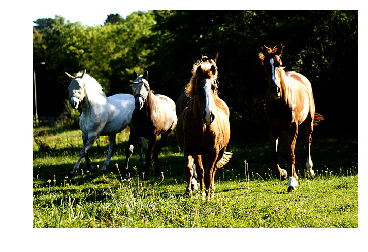

Bigram overlap:	0.2699	a flock of birds sitting on top of a sandy beach
Beam:		1.0000	a flock of birds flying over a beach
Annotations: 
		 a flock of birds flying over a beach near the ocean
		 a large number of seagulls flying and standing on the beach
		 a beach with many seagulls on the ground and many more flying over them
		 a flock of seagulls are standing on the beach
		 a crowded beach with birds landing and flying


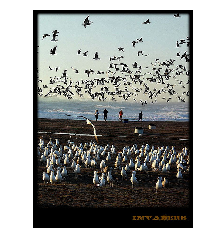

Bigram overlap:	0.2981	a blender sitting on top of a counter in a kitchen
Beam:		1.0000	a blender that is sitting on a counter
Annotations: 
		 a blender is shown on a kitchen counter next to a sink
		 a blender sits on a counter top unplugged
		 a black blender sitting on a counter unplugged
		 a blender sitting on a counter near a sink
		 a blender that is sitting on a kitchen counter


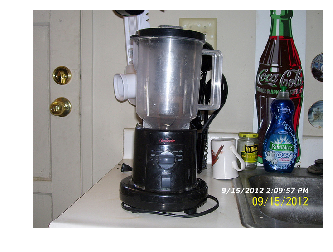

Bigram overlap:	0.3043	a dog a frisbee in a field
Beam:		1.0000	a group of dogs that are standing in the grass
Annotations: 
		 four smaller dogs are running away from the women on the bench 
		 a group of dogs running across a lush green field
		 a number of dogs running in a field with people on a bench
		 a group of dogs that are standing in the grass
		 a bunch of dogs running around in a field 


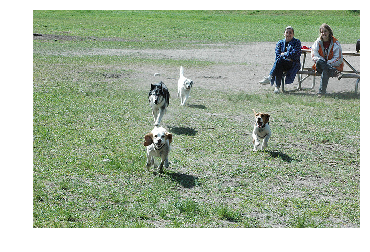

Bigram overlap:	0.3170	a baseball player swinging a bat on top of a field
Beam:		1.0000	a batter catcher and umpire during a baseball game
Annotations: 
		 a baseball player about to swing at a pitch during a game
		 a batter in a baseball game ready to hit the ball
		 a batter catcher and umpire during a baseball game
		 a batter at a baseball game preparing to hit the ball 
		 a batter at home plate getting ready to hit the ball 


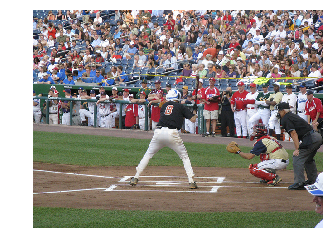

Bigram overlap:	0.3226	a giraffe standing next to a wooden fence
Beam:		1.0000	a couple of giraffe standing next to each other
Annotations: 
		 a couple of giraffe standing next to each other
		 a pair of giraffes stand next to rocks on the grass
		 two giraffes out in a field walking around the grass
		 two giraffes are wandering around an area with trees and rocks
		 two giraffes standing in an enclosure with green grass and rocks


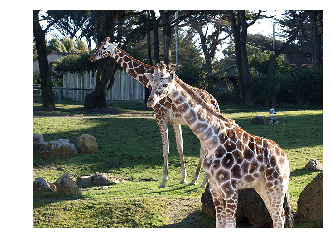

Bigram overlap:	0.3247	a red double decker bus driving down a city street
Beam:		1.0000	a city street filled with lots of traffic
Annotations: 
		 a city street filled with lots of traffic and pedestrians
		 a mostly grey european cityscape with buildings and lots of traffic vehicular and otherwise picks up bits of bright red from buses stop signs sidewalk signs and pedestrian clothing items 
		 a busy road in london shows several red busses and smaller cars as pedestrians walk next to them 
		 a busy street with multiple cars and many pedestrians
		 during the day many people occupy the street


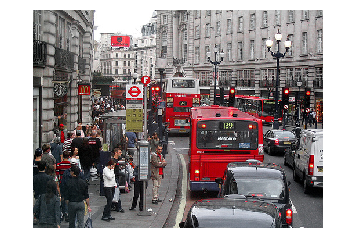

Bigram overlap:	0.3318	a baseball player swinging a bat on top of a field
Beam:		1.0000	a batter catcher and umpire during a baseball game
Annotations: 
		 a baseball player with the cardinals getting ready to hit a baseball
		 the man is getting ready to hit the ball in the baseball game 
		 some ball players are looking home plate and talking
		 a baseball player holding a baseball bat during a game
		 a batter catcher and umpire during a baseball game


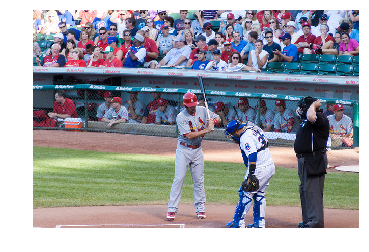

Bigram overlap:	0.3357	a woman swinging a tennis racquet on a tennis court
Beam:		1.0000	a woman standing on a tennis court holding a racquet
Annotations: 
		 female tennis player running to intercept the ball
		 a woman standing on a tennis court holding a racquet
		 a woman in a white dress holding a racquet 
		 a tennis player running and looking up to find the ball
		 a tennis player is getting ready to hit a ball


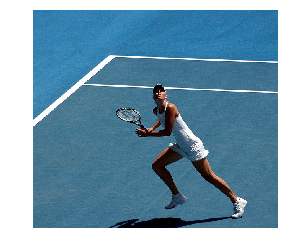

Bigram overlap:	0.3433	a little girl sitting at a table with a cake
Beam:		1.0000	a little girl sitting in front of a cake
Annotations: 
		 a little girl sitting in front of a cake plate
		 a girl smiles down at a train cake
		 a little girl holding a dessert made of little cakes in the shape of train cars
		 a girl is looking at a vehicle themed birthday cake
		 a girl is holding a pastry designed to look like cars


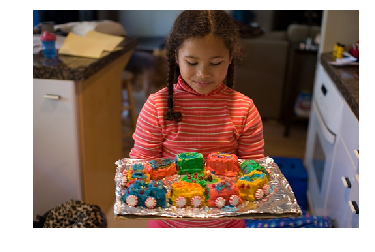

In [94]:
for idx in diff_idxs[:10]:
    print("Bigram overlap:\t{:.4f}\t{}".format(vote_sentence_bleus[idx], " ".join(caption_sentences[idx])))
    print("Beam:\t\t{:.4f}\t{}".format(beam_sentence_bleus[idx], " ".join(beam_captions[idx])))
    print("Annotations: ")
    for annotation in annotations_list[idx]:
        print("\t\t"," ".join(annotation))
    utils.print_image(idx)
    plt.show()

21837
Bigram overlap:	1.0000	a man riding a skateboard up the side of a ramp
Beam:		0.3976	a man flying through the air while riding a skateboard
Annotations: 
		 a man on a skateboard is coming up a ramp
		 a boy skateboards in a skate park pike 
		 a man riding a skateboard up the side of a ramp
		 a boy on a skateboard at the skate park
		 a skate board rider skating on the edge of a ramp


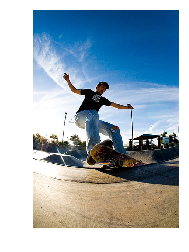

35231
Bigram overlap:	0.9554	a group of people standing around in the snow
Beam:		0.3508	a group of people standing on top of a snow covered slope
Annotations: 
		 a crowd of people standing outside of a hotel on snow covered ground
		 dozens of people standing around in the snow near a hotel
		 many people outside at a winter event in the mountains
		 a group is gathered outside in the snow
		 a group of people that are standing in the snow


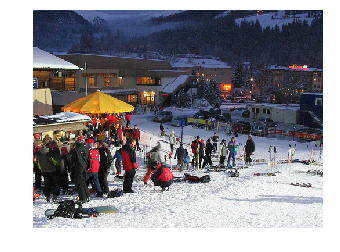

27729
Bigram overlap:	0.8739	a herd of sheep standing on top of a lush green field
Beam:		0.2521	a herd of sheep standing on top of a grass covered field
Annotations: 
		 sheep and lambs with green paint on their backs
		 a dog laying in the grass next to baby sheep
		 a dog laying on the ground playing with a couple of lambs
		 two lambs approach a border collie while other sheep eat from a trough
		 a black and white dog sitting on a grass covered field


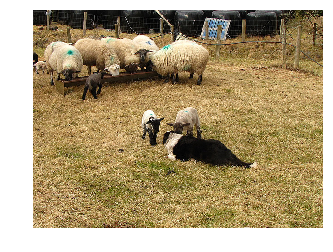

6843
Bigram overlap:	0.9235	a black and white photo of a man sitting on a bench
Beam:		0.2907	a couple of people that are sitting on a bench
Annotations: 
		 a man sitting on a bench reading in a city
		 black and white photo of a man sitting on a bench
		 a man sitting on a bench reading a book
		 a man sitting on a bench near a busy street
		 a man sitting on a bench in a busy city


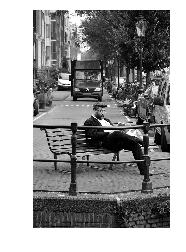

19813
Bigram overlap:	1.0000	a woman holding a tennis racquet on a tennis court
Beam:		0.3656	a woman standing on a tennis court holding a racquet
Annotations: 
		 woman in red shirt holding up a tennis racket on a court 
		 a strong woman is playing tennis on a court
		 woman in red shirt getting ready to hit tennis ball
		 a women who is about to swing at the ball while playing tennis
		 a woman holding a tennis racquet on a tennis court


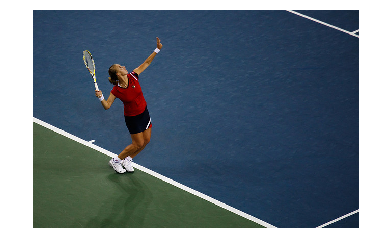

6494
Bigram overlap:	1.0000	a man holding a tennis racquet on a tennis court
Beam:		0.3656	a man standing on a tennis court holding a racquet
Annotations: 
		 the tennis player looks upset about the game
		 a man celebrating with a tennis racket in his hand
		 a tennis player in yellow shirt with striped shorts
		 a man holding a tennis racquet on a tennis court
		 a man with a tennis racket walking on a court


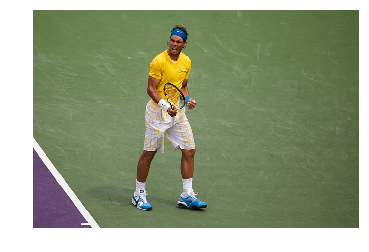

11238
Bigram overlap:	1.0000	a plane sitting on the tarmac at an airport
Beam:		0.3549	a plane sitting on top of an airport runway
Annotations: 
		 a plane is parked near the pretty blue ocean 
		 a large white airplane parked next to some water
		 there is a plane getting ready for boarding or exiting
		 there is a baggage trolley parked next to a plane
		 a plane sitting on the tarmac at an airport


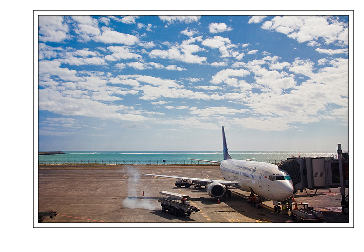

5011
Bigram overlap:	0.6534	a close up of a on a
Beam:		0.0003	a
Annotations: 
		 this is a teddy bear birthday cake for someone turning 30
		 a large card with a mini birthday cake on it and a teddy bear 
		 a 30th birthday cake shaped as a teddy bear
		 a thirtieth birthday cake made like a teddy bear
		 one small cake is next to a bigger one designed like a old teddy bear


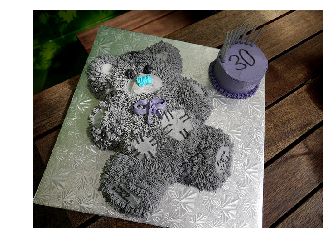

38673
Bigram overlap:	1.0000	a baseball player swinging a bat at a ball
Beam:		0.3433	a batter catcher and umpire during a baseball game
Annotations: 
		 two kids in blue shirts playing a game of baseball
		 a baseball player swinging a bat at a ball
		 a person getting ready to bat while a catcher waits behind him and people watch from the bleachers
		 a boy swings a bat during a baseball game as spectators look on
		 people playing baseball and others watching them as they play
		 a young baseball player swings a bat as a ball comes toward him


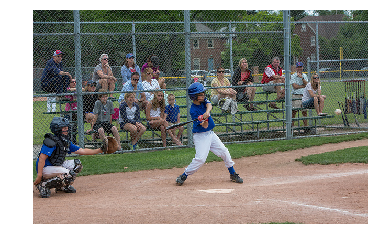

5320
Bigram overlap:	1.0000	a group of people playing frisbee in a field
Beam:		0.3247	a group of people that are standing in the grass
Annotations: 
		 people watch an ultimate frisbee game in the park 
		 a large group of people playing frisbee with onlookers
		 a number of people playing frisbee in a field 
		 a group of people standing on top of a lush green field
		 people watching young boys playing a game of some sort


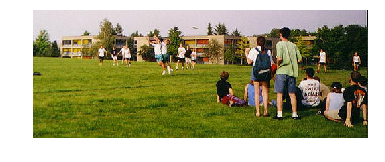

In [97]:
for idx in diff_idxs[-10:]:
    print(idx)
    print("Bigram overlap:\t{:.4f}\t{}".format(vote_sentence_bleus[idx], " ".join(caption_sentences[idx])))
    print("Beam:\t\t{:.4f}\t{}".format(beam_sentence_bleus[idx], " ".join(beam_captions[idx])))
    print("Annotations: ")
    for annotation in annotations_list[idx]:
        print("\t\t"," ".join(annotation))
    utils.print_image(idx)
    plt.show()

In [115]:
beam_captions_dir = "../../outputs/beam_captions_10/"
poor_beam_caption_object = load_caption(6843, image_dir=beam_captions_dir)
for caption in poor_beam_caption_object['captions']:
    print("\item {:.5f}: {}".format(caption['probability'], " ".join(decode_caption(caption['sentence'], vocab))))

\item 0.00230: a couple of people that are sitting on a bench
\item 0.00132: a man sitting on a bench next to a dog
\item 0.00079: a black and white photo of a man sitting on a bench
\item 0.00075: a couple of people sitting on a bench
\item 0.00066: a man sitting on a bench with a dog
\item 0.00064: a man and a woman sitting on a bench
\item 0.00048: a man and a woman sitting on a park bench
\item 0.00046: a black and white photo of a man and a horse
\item 0.00033: a black and white photo of a man and a dog
\item 0.00025: a black and white photo of a man on a horse
